In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io as io
import glob
import xml.etree.ElementTree as ET

In [5]:
# Directories containing images
dataDir = 'images'
annDir = 'val'
fileLabel = 'ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt'
fileLabelNames = 'labelNames.txt'
fileImageNetNames = 'ImageNetLabels.txt'

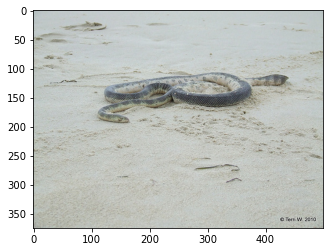

In [6]:
fileName = 'ILSVRC2012_val_00000001.JPEG'
I = io.imread( '%s/%s'%(dataDir,fileName) )
plt.imshow(I)
plt.show()

In [7]:
# Load label names into a dictionary
dictIDtoWNID = {}
dictWNIDtoID = {}
dictWNIDtoLabel = {}

with open( fileLabelNames ) as f:

    for line in f:

        line = line.rstrip()
        (ID, WNID, labels) = line.split( ',', maxsplit=2 )
        labels.replace( '"', '' )
        listLabels = labels.split( ',' )
        dictIDtoWNID[ ID ] = WNID
        dictWNIDtoID[ WNID ] = ID
        dictWNIDtoLabel[ WNID ] = labels

dictValidLabels = {}
i=0

# Load ground truth validation into a dictionary
with open( fileLabel ) as f:

    for line in f:

        dictValidLabels[i] = line.rstrip()
        i += 1

dictLabels = {}
i=0

with open( fileImageNetNames ) as f: 

    for line in f:

        dictLabels[i] = line.rstrip()
        i += 1

In [8]:
print( len( dictIDtoWNID.keys() ) )
WNID = dictIDtoWNID[ '490' ]
print( WNID )
print( dictWNIDtoLabel[ WNID ] )

1861
n01751748
"sea snake"


In [9]:
# Real labels on the imported GoogLeNet from TensorFlow
print( dictLabels[ 803 ] )
#dictValidLabels[ 0 ]

snowmobile


In [84]:
def _bytes_feature(value):

    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Create a dictionary with features that may be relevant.
def image_example(image_string, label, bbox):

    feature = {

        'image': _bytes_feature(image_string),
        'label': _bytes_feature(label),
        'bbox': _bytes_feature(bbox),

    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


# From:
# https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array


In [95]:
# Write TFRecord
numEmpty = 0
numImgs = 0
fileCount = 0

# TFRecord Parameters
writer = None
recPath = 'records'
recName = 'ImageNet'
recordCount = 1
    # Number of examples per TFRecord file
    #   According to recommended size of TFRecord -> X / (10*N), where X = numGbs & N = 1 host
    #   ~ 1GB per file
fragment_size = 1500    


# Iterate through all images of a specific extension in the specified directory
imgPath = os.path.join( dataDir, '*.jpeg' )
dictFiles = {}

for filepath in glob.iglob( imgPath ):

    # Write to a new TFRecord after hitting a certain size
    if fileCount % fragment_size == 0:

        if writer is not None:
            writer.close()

        filename = os.path.join(recPath, 
            recName + '-' + str(recordCount) + '.tfrecords')
        print('Writing', filename)
        writer = tf.io.TFRecordWriter(filename)
        recordCount += 1
        

    # Get filename from the path
    fileName = os.path.basename(filepath)
    fileName = os.path.splitext(fileName)[0]
    annFile = fileName + '.xml'
    annsName = os.path.join( annDir, annFile )

    tree = ET.parse(annsName)
    root = tree.getroot()

    # Iterate through the objects present
    # objCount = 0
    # dictObjs = {}
    # tempDict = {}
    labelList = []
    bboxList = []
    
    for ex in root.findall('object'):
        
        bbox = []

        # Get name
        name = ex.find('name').text
        box = ex.find('bndbox')

        # Get bounding box
        bbox.append( int(box.find('xmin').text) )
        bbox.append( int(box.find('ymin').text) )
        bbox.append( int(box.find('xmax').text) )
        bbox.append( int(box.find('ymax').text) )

        label = dictWNIDtoID[name]
        # print( label )
        # print( dictValidLabels[fileCount] )

        # Ensure the label on the annotations matches the label on the ground truth validation text file
        assert( label == dictValidLabels[fileCount] )

        bboxList.append( bbox )

        # tempDict[ name ] = bbox
        # dictObjs[ objCount ] = tempDict
        # objCount += 1

    I = io.imread( filepath )
    image_string = serialize_array( I )
    label_string = serialize_array( label )
    bbox_string = serialize_array( bboxList )

    # Write to file
    tf_example = image_example(image_string, label_string, bbox_string)
    writer.write(tf_example.SerializeToString())
    #dictFiles[ fileName ] = dictObjs

    fileCount += 1
    # if fileCount == 5:
    #     break

# print( dictFiles['ILSVRC2012_val_00000001'])
# print()
# print( dictFiles['ILSVRC2012_val_00000002'])

print( "Finished writing" )

Writing records\ImageNet-1.tfrecords
Writing records\ImageNet-2.tfrecords
Writing records\ImageNet-3.tfrecords
Writing records\ImageNet-4.tfrecords
Writing records\ImageNet-5.tfrecords
Writing records\ImageNet-6.tfrecords
Writing records\ImageNet-7.tfrecords
Writing records\ImageNet-8.tfrecords
Writing records\ImageNet-9.tfrecords
Writing records\ImageNet-10.tfrecords
Writing records\ImageNet-11.tfrecords
Writing records\ImageNet-12.tfrecords
Writing records\ImageNet-13.tfrecords
Writing records\ImageNet-14.tfrecords
Writing records\ImageNet-15.tfrecords
Writing records\ImageNet-16.tfrecords
Writing records\ImageNet-17.tfrecords
Writing records\ImageNet-18.tfrecords
Writing records\ImageNet-19.tfrecords
Writing records\ImageNet-20.tfrecords
Writing records\ImageNet-21.tfrecords
Writing records\ImageNet-22.tfrecords
Writing records\ImageNet-23.tfrecords
Writing records\ImageNet-24.tfrecords
Writing records\ImageNet-25.tfrecords
Writing records\ImageNet-26.tfrecords
Writing records\Image

In [93]:
# Read TFRecord file from:
# https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
def _parse_tfr_element(element):

    parse_dic = {
            'image': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
            'label': tf.io.FixedLenFeature([], tf.string),
            'bbox': tf.io.FixedLenFeature([], tf.string),
    }
    example_message = tf.io.parse_single_example(element, parse_dic)

    b_image = example_message['image'] # get byte string
    b_label = example_message['label']
    b_bbox = example_message['bbox']

    
    # Get height and width of image
    img = tf.io.parse_tensor(b_image, out_type=tf.uint8) # restore 2D array from byte string
    bbox = tf.io.parse_tensor(b_bbox, out_type=tf.int32)
    label = tf.io.parse_tensor(b_label, out_type=tf.string)
    label = int(label)

    return img, label, bbox


tf.Tensor([375 500   3], shape=(3,), dtype=int32)
tf.Tensor(490, shape=(), dtype=int32)
tf.Tensor([[111 108 441 193]], shape=(1, 4), dtype=int32)


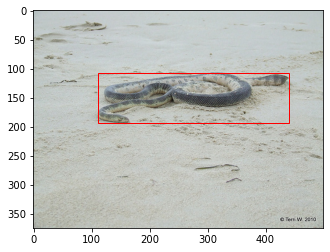


tf.Tensor([375 500   3], shape=(3,), dtype=int32)
tf.Tensor(361, shape=(), dtype=int32)
tf.Tensor(
[[ 45  49 499 162]
 [  2  69 437 207]], shape=(2, 4), dtype=int32)


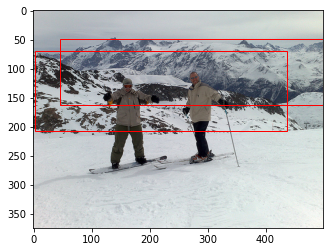


tf.Tensor([375 500   3], shape=(3,), dtype=int32)
tf.Tensor(171, shape=(), dtype=int32)
tf.Tensor([[ 38  19 385 373]], shape=(1, 4), dtype=int32)


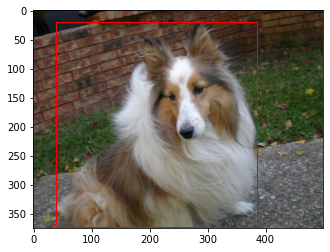


tf.Tensor([375 500   3], shape=(3,), dtype=int32)
tf.Tensor(822, shape=(), dtype=int32)
tf.Tensor([[ 94  15 441 284]], shape=(1, 4), dtype=int32)


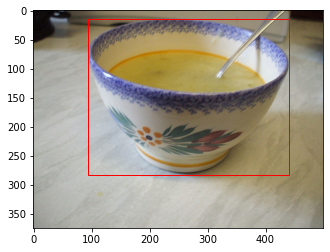


tf.Tensor([333 500   3], shape=(3,), dtype=int32)
tf.Tensor(297, shape=(), dtype=int32)
tf.Tensor([[ 17   1 425 332]], shape=(1, 4), dtype=int32)


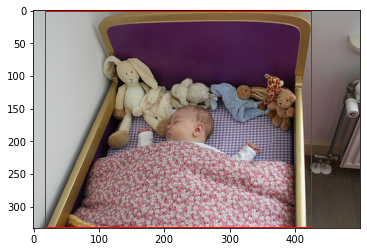

InvalidArgumentError: Type mismatch between parsed tensor (int32) and dtype (string)
	 [[{{node ParseTensor_2}}]]

In [94]:
# Test Reading TFRecord
filename = [ os.path.join(recPath, recName + '-' + '1' + '.tfrecords'), 
            os.path.join(recPath, recName + '-' + '2' + '.tfrecords') ]
tfr_dataset = tf.data.TFRecordDataset(filename) 

dataset = tfr_dataset.map(_parse_tfr_element)
#dataset = dataset.map(map_func)
#print( dataset.take(1) )
# Test mapping function
#ds = dataset.map( lambda img, bbox, label: map_func( img, bbox, label ) )

for img, label, bbox in dataset.take(20):
    
    print()
    print( tf.shape(img) )
    print( label )
    print( bbox )

    fig, ax = plt.subplots()
    ax.imshow( img )

    # Plot bounding box
    for i in range( len(bbox) ):

        bboxTemp = np.array( bbox[i] )
        height = bboxTemp[2] - bboxTemp[0]
        width = bboxTemp[3] - bboxTemp[1]
        ax.add_patch( patches.Rectangle( bboxTemp, height, width, fill=False, color='r' ) )
    
    plt.show()